In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/task/bbc_data.csv')

In [27]:
df['labels'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

In [5]:
# Preprocess the data
df['labels'] = df['labels'].astype('category').cat.codes  # Convert labels to numeric values
X = df['data'].tolist()
y = df['labels'].tolist()

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model che

In [11]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

In [12]:
# Prepare datasets
train_encodings = tokenizer(X_train, padding=True, truncation=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test, padding=True, truncation=True, max_length=128, return_tensors='pt')

In [13]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'].numpy(),
    'attention_mask': train_encodings['attention_mask'].numpy(),
    'labels': y_train
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'].numpy(),
    'attention_mask': test_encodings['attention_mask'].numpy(),
    'labels': y_test
})

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"  # Evaluate after each epoch
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)


In [19]:
def evaluate_model():
    # Move model to the appropriate device
    device = model.device
    model.to(device)

    # Tokenize the test data
    test_encodings = tokenizer(X_test, padding=True, truncation=True, max_length=128, return_tensors='pt')

    # Move tensors to the same device as the model
    input_ids = test_encodings['input_ids'].to(device)
    attention_mask = test_encodings['attention_mask'].to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions_before_fine_tuning = torch.argmax(logits, dim=-1).tolist()

    # Compute accuracy
    accuracy_before = accuracy_score(y_test, predictions_before_fine_tuning)
    return accuracy_before


In [20]:
accuracy_before = evaluate_model()
print("Accuracy before fine-tuning:", accuracy_before)

Accuracy before fine-tuning: 0.2202247191011236


In [21]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.150596,0.957303
2,No log,0.196778,0.959551
3,0.464600,0.120466,0.979775


TrainOutput(global_step=669, training_loss=0.36342497684495867, metrics={'train_runtime': 83.8561, 'train_samples_per_second': 63.68, 'train_steps_per_second': 7.978, 'total_flos': 176853438489600.0, 'train_loss': 0.36342497684495867, 'epoch': 3.0})

In [22]:
# Evaluate the model after fine-tuning
results = trainer.evaluate()
accuracy_after = results['eval_accuracy']
print("Accuracy after fine-tuning:", accuracy_after)


Accuracy after fine-tuning: 0.9797752808988764


In [23]:
# Plotting
labels = ['Before Fine-Tuning', 'After Fine-Tuning']
accuracies = [accuracy_before, accuracy_after]

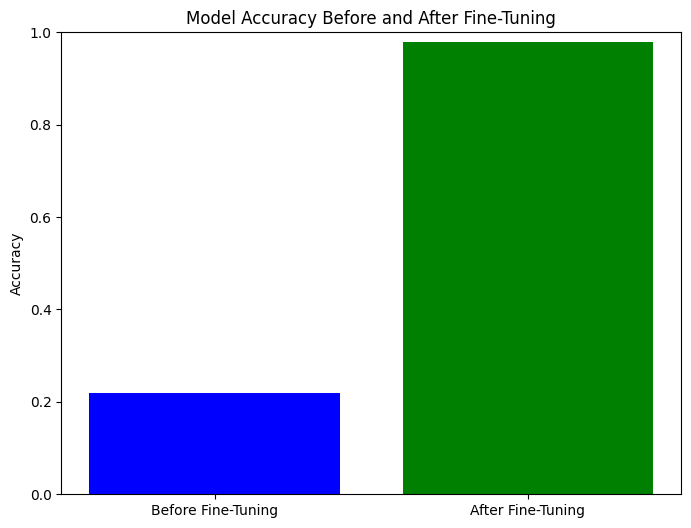

In [24]:
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Before and After Fine-Tuning')
plt.ylim([0, 1])
plt.show()

In [26]:
import os

# Define save paths
pretrained_model_save_path = '/content/drive/MyDrive/task/pretrained_model'
fine_tuned_model_save_path = '/content/drive/MyDrive/task/fine_tuned_model'
tokenizer_save_path = '/content/drive/MyDrive/task/fine_tuned_model/tokenizer'

# Save the pre-trained model and tokenizer
model.save_pretrained(pretrained_model_save_path)
tokenizer.save_pretrained(pretrained_model_save_path)

print(f"Pre-trained model and tokenizer saved to {pretrained_model_save_path}")

# Fine-tune the model
trainer.train()

# Save the fine-tuned model and tokenizer
os.makedirs(fine_tuned_model_save_path, exist_ok=True)
model.save_pretrained(fine_tuned_model_save_path)
tokenizer.save_pretrained(fine_tuned_model_save_path)

print(f"Fine-tuned model and tokenizer saved to {fine_tuned_model_save_path}")


Pre-trained model and tokenizer saved to /content/drive/MyDrive/task/pretrained_model


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.075714,0.986517
2,No log,0.126991,0.973034
3,0.020700,0.141487,0.977528


Fine-tuned model and tokenizer saved to /content/drive/MyDrive/task/fine_tuned_model
